In [1]:
# Required imports
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.preprocessing import StandardScaler

In [2]:
# Import findspark and initialize. 
import findspark
findspark.init()

# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()


heart_df = spark.read.csv("heart_failure_clinical_records_dataset.csv", sep=",", header=True)
heart_df.show()


+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+---+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
| 75|      0|                     582|       0|               20|                  1|   265000|             1.9|         130|  1|      0|   4|          1|
| 55|      0|                    7861|       0|               38|                  0|263358.03|             1.1|         136|  1|      0|   6|          1|
| 65|      0|                     146|       0|               20|                  0|   162000|             1.3|         129|  1|      1|   7|          1|
| 50|      1|                     111|       0|               20|     

In [3]:
heart_df.describe()

DataFrame[summary: string, age: string, anaemia: string, creatinine_phosphokinase: string, diabetes: string, ejection_fraction: string, high_blood_pressure: string, platelets: string, serum_creatinine: string, serum_sodium: string, sex: string, smoking: string, time: string, DEATH_EVENT: string]

In [4]:
# Data preprocessing
X = heart_df.drop('DEATH_EVENT')
y = heart_df.select('DEATH_EVENT')

In [5]:
# Convert PySpark DataFrames to Pandas DataFrames
X_pd = X.toPandas()
y_pd = y.toPandas()

In [6]:
#Train-test split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, random_state=1, 
                                                    stratify=y_pd)

In [7]:
#More Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [8]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [9]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [10]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [11]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [12]:
## Making Predictions using Random Forest Model

In [13]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

C:\Users\piyu_\AppData\Local\Temp\ipykernel_21120\478868177.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model = rf_model.fit(X_train_scaled, y_train)


In [14]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [15]:
## Model Evaluation

In [16]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [17]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,44,7
Actual 1,8,16


Accuracy Score : 0.8
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        51
           1       0.70      0.67      0.68        24

    accuracy                           0.80        75
   macro avg       0.77      0.76      0.77        75
weighted avg       0.80      0.80      0.80        75



In [18]:
#According to this confusion matrix, our model is correctly predicting 80% of the cases(Which is told by accuracy score - 0.8).
#Also we can see that model perform realtively well in predicting class 0(Which is if Patient Survived) 
#but there is a room for improvment in predicting class 1(which is Patient Died)

In [19]:
## Feature Importance

In [20]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.3283832201148634, 'time'),
 (0.15196502317211993, 'serum_creatinine'),
 (0.1491633829380517, 'ejection_fraction'),
 (0.08035483369100883, 'platelets'),
 (0.07918046144408693, 'creatinine_phosphokinase'),
 (0.07758510602767571, 'serum_sodium'),
 (0.07581036799980256, 'age'),
 (0.014839309003849614, 'sex'),
 (0.012468159233467902, 'anaemia'),
 (0.012150590067226142, 'diabetes'),
 (0.009335354368504994, 'high_blood_pressure'),
 (0.008764191939342067, 'smoking')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

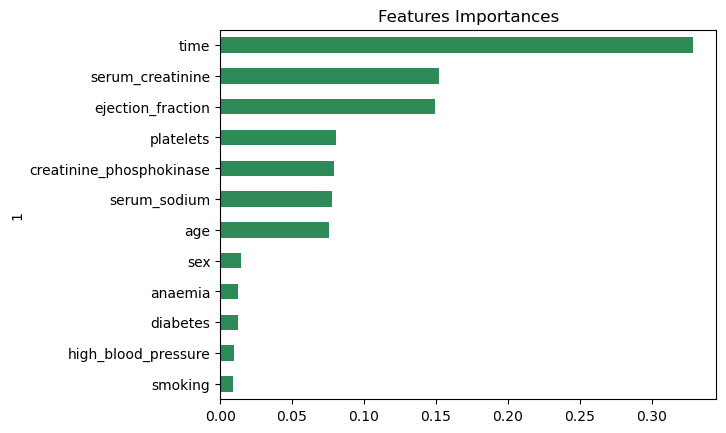

In [21]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='seagreen', title= 'Features Importances', legend=False)

In [22]:
## Create a Logistic Regression Model

In [23]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs', random_state=1)
classifier

LogisticRegression(random_state=1)

In [24]:
## Fit (train) or model using the training data

In [25]:
# Train the data
classifier.fit(X_train, y_train)

C:\Users\piyu_\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=1)

In [26]:
## Validate the model using the test data

In [27]:
# Score the model
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8348214285714286
Testing Data Score: 0.7733333333333333


In [28]:
## Make predictions

In [29]:
# Predict outcomes for test data set
predictions = classifier.predict(X_test)
y_test = y_test.values.ravel()

In [30]:
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,1
6,0,0
7,0,0
8,0,0
9,0,0


In [31]:
## Calculate the Accuracy Score

In [32]:
from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.7733333333333333

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[43,  8],
       [ 9, 15]], dtype=int64)

In [34]:
from sklearn.metrics import classification_report
target_names = ["Death Event", "Comorbidity"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 Death Event       0.83      0.84      0.83        51
 Comorbidity       0.65      0.62      0.64        24

    accuracy                           0.77        75
   macro avg       0.74      0.73      0.74        75
weighted avg       0.77      0.77      0.77        75



In [35]:
# While we compare the RandomForestClassifier model with Logistic Regression model, we can see that Model1 has slightly higher accuracy as compared to Model2.
#Also, Model 1 performs better overall, particularly in terms of accuracy and the performance metrics for class 1 (Comorbidity). So Model1 is more preffered due
# to its higher accuracy and classification matrics.

In [36]:
heart_pd = heart_df.toPandas()

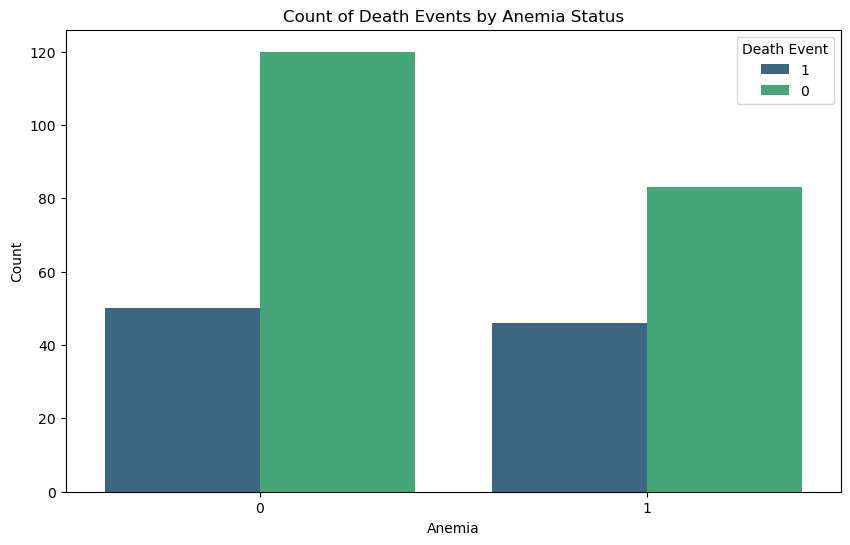

In [37]:
#Plotting count of Death Events wrt to Anameia Status of Patients
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=heart_pd, x='anaemia', hue='DEATH_EVENT', palette='viridis')
plt.title('Count of Death Events by Anemia Status')
plt.xlabel('Anemia')
plt.ylabel('Count')
plt.legend(title='Death Event')
plt.show()



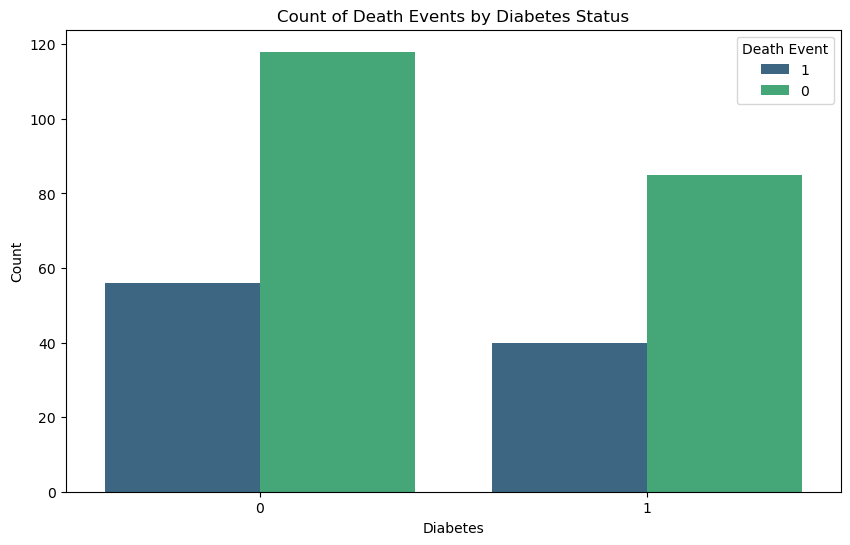

In [38]:
#Plotting count of Death Events wrt Patients having Diabetes
plt.figure(figsize=(10, 6))
sns.countplot(data=heart_pd, x='diabetes', hue='DEATH_EVENT', palette='viridis')
plt.title('Count of Death Events by Diabetes Status')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.legend(title='Death Event')
plt.show()


In [39]:
#Scatter plot for age vs serum_creatinine(high when kidney function declines)
heart_pd.hvplot.scatter(x="age", y="serum_creatinine", by='DEATH_EVENT')

:NdOverlay   [DEATH_EVENT]
   :Scatter   [age]   (serum_creatinine)

In [40]:
#Plot of age vs. ejection_fraction(amount of blood the left ventricle of the heart pumps out to your body with each heartbeat)
heart_pd.hvplot.scatter(x="age", y="ejection_fraction", by='DEATH_EVENT')

:NdOverlay   [DEATH_EVENT]
   :Scatter   [age]   (ejection_fraction)

In [41]:
heart_pd.hvplot.scatter(x="age", y="time", by='DEATH_EVENT')

:NdOverlay   [DEATH_EVENT]
   :Scatter   [age]   (time)

In [42]:
#Scatter plot for age vs creatinine_phosphokinase(help diagnose and monitor various conditions related to muscle damage, heart conditions, and other medical issues.)
heart_pd.hvplot.scatter(x="age", y="creatinine_phosphokinase", by='DEATH_EVENT')

:NdOverlay   [DEATH_EVENT]
   :Scatter   [age]   (creatinine_phosphokinase)

In [43]:
#Scatter plot for age vs platelets(small blood cells that help stop bleeding by forming clots)
heart_pd.hvplot.scatter(x="age", y="platelets", by='DEATH_EVENT')

:NdOverlay   [DEATH_EVENT]
   :Scatter   [age]   (platelets)

In [44]:
#Scatter plot for age vs serum_sodium(Sodium is an electrolyte, and it helps regulate the amount of water that's in and around your cells)
heart_pd.hvplot.scatter(x="age", y="serum_sodium", by='DEATH_EVENT')

:NdOverlay   [DEATH_EVENT]
   :Scatter   [age]   (serum_sodium)